**该notebook以titanic数据为例，梳理了一些ml建模常用的操作，包括如下一些内容：**   

1. 理解数据并可视化分析(pandas,seaborn)  

2. 数据清洗：NaN的不同填充方法、categorical 变量的处理、数据归一化操作(z-score,min-max,normalize,log,boxcox等)  

3. 模型选择(方差-偏差、过拟合-欠拟合)  

4. 优化，包括：  

    4.1 特征增强
        4.1.1 异常值处理：cap_floor（盖帽）
        4.1.2 特征优化：根据背景知识造特征、聚类算法构建新特征、长尾数据的log变换、boxcox、cdf、pdf变换；构建组合特征，自动构建组合特征(gbdt+lr)；构建交互式特征；  

        4.1.3 特征选择：基于统计方法的方差、相关性、gini、mi、chi2选择等，基于模型的迭代消除法等；  

        4.1.4 特征变换：pca、lda、lle(局部线性嵌入)、ae（自编码）、vae（变分自编码）等  

    4.2 数据增强：半监督学习、过采样、根据数据特征造新数据  
    
    4.3 模型增强：
        4.3.1 超参优化：随机搜索、网格搜索、贝叶斯优化
        4.3.2 集成学习：stacking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

导入数据：

Survived:0代表死亡，1代表存活

Pclass:乘客所持票类

Name:乘客姓名

Sex:乘客性别

Age:乘客年龄

SibSp:乘客兄弟姐妹/配偶的个数

Parch:乘客父母/孩子的个数

Ticket:票号

Fare:乘客所持票的价格

Cabin:乘客所在船舱

Embarked:乘客登船港口:S、C、Q

In [2]:
train_df=pd.read_csv('./titanic/train.csv')
test_df=pd.read_csv('./titanic/test.csv')

### 一.理解数据

In [3]:
#查看shape
'训练集：',train_df.shape,'测试集',test_df.shape

('训练集：', (891, 12), '测试集', (418, 11))

In [4]:
#查看数据前几行
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


测试集相对于训练集少了Survived，即任务目标，为了方便后续的各种处理，这里将数据合并，并切分为features部分以及labels部分

In [6]:
labels=train_df['Survived']
origin_features_df=pd.concat([train_df.drop(columns=['Survived']),test_df]).reset_index(drop=True)
features_df=copy.deepcopy(origin_features_df)

In [7]:
features_df.shape

(1309, 11)

In [8]:
features_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
labels.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [10]:
#查看数据条数、每个特征的缺失值个数、特征类型
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


### 1.1特征分类

表现\功能 | 离散型特征 |  数值型特征  
:- | :-: | -:
int,float | PassengerId,**Pclass** | Age,**Pclass**,SibSp,Parch,Fare 
str | Name,Sex,Ticket,Cabin,Embarked |  

从功能上我们可以简单把数据分为两类，一类是离散型特征、一类是数值型特征：  

（1）数值型特征：对**“比较大小”**有意义的特征，比如“高、中、低”，“优秀、良好、一般、差”等这一类特征可以看做数值型特征

（2）离散型特征：PassengerId虽然表现为int，但对其比较大小并无实际意义

In [11]:
#进一步，查看int,float特征的分布
features_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [12]:
#对于object类型特征，也可以使用describe查看最频繁的那一项,以及总的有多少项
features_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [13]:
#通过value_counts查看靠前的项目
features_df['Cabin'].value_counts().head(5)

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F2                 4
D                  4
Name: Cabin, dtype: int64

### 1.2可视化

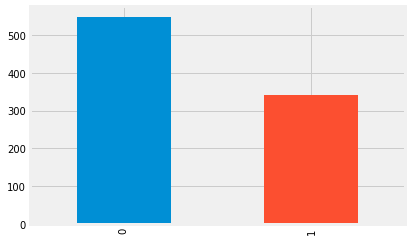

In [14]:
#条形图，存活分布
labels.value_counts().plot(kind='bar')

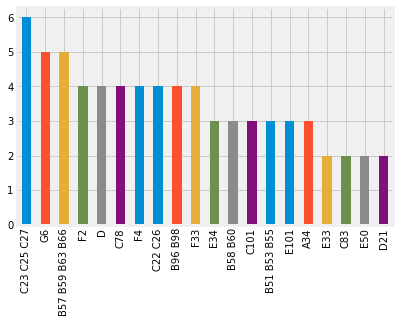

In [15]:
#条形图：查看Cabin的分布
features_df['Cabin'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')

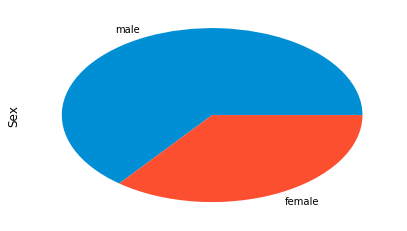

In [16]:
#饼图，查看性别分布
features_df['Sex'].value_counts().sort_values(ascending=False).plot(kind='pie')

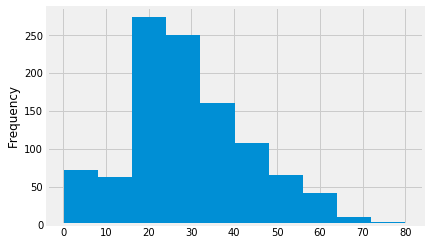

In [17]:
#直方图，查看年龄分布
features_df['Age'].plot(kind='hist')#注意：有别于条形图，这里会将连续值“分箱”

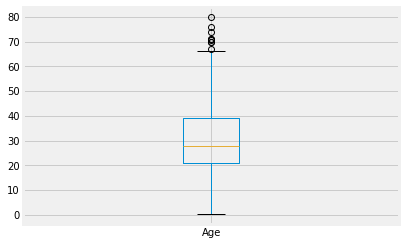

In [18]:
#箱线图，查看年龄分布
features_df['Age'].plot(kind='box')#可见有绝大部分是20-40岁的年轻人

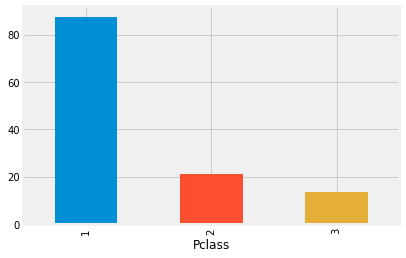

In [19]:
#条形图：查看票价与票类的关系
features_df.groupby('Pclass')['Fare'].mean().plot(kind='bar')#Pclass 1,2,3分别表示头等舱、一等舱、二等舱

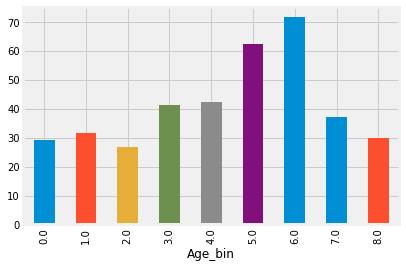

In [20]:
#将年龄分成1-10的10个阶段，并统计对应票价
def age_bin(x):
    try:
        return int(x/10)
    except:
        None
features_df['Age_bin']=features_df['Age'].apply(age_bin)
features_df.groupby('Age_bin')['Fare'].mean().plot(kind='bar')

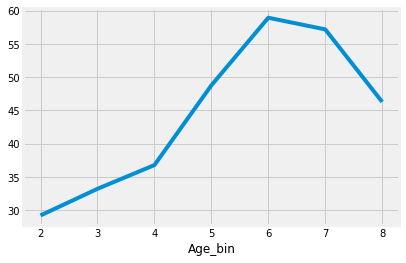

In [21]:
#平滑处理
features_df.groupby('Age_bin')['Fare'].mean().rolling(3).mean().plot(kind='line')#注意:前rolling_num-1项会为None

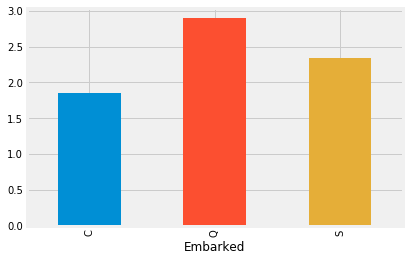

In [22]:
#查看各登船港口与票类的关系
features_df.groupby('Embarked')['Pclass'].mean().plot.bar()

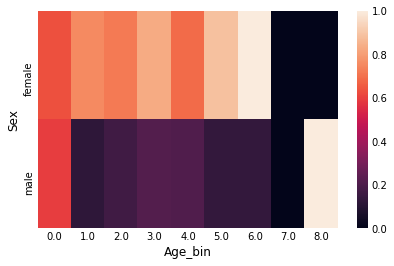

In [23]:
#探索不同性别，不同年龄段的存活率
show_df=features_df[:891]
show_df['Survived']=labels
show_df=show_df.groupby(['Sex','Age_bin'])['Survived'].mean().reset_index().pivot(index='Sex',columns='Age_bin',values='Survived').reset_index()
show_df=show_df.where(show_df.notnull(),0)
show_df.set_index('Sex',inplace=True,drop=True)
sns.heatmap(show_df)

**注意float.nan无法通过fillna填充**  

可以发现婴儿和女性的存活率更高

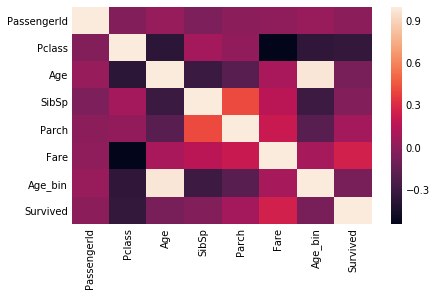

In [24]:
#热图：探索不同特征之间的相关系数
show_df=features_df[:891]
show_df['Survived']=labels
sns.heatmap(show_df.corr())

可以发现是否存活与Fare/票价的正相关性最强，与Pclass负相关性最强

### 二.清洗特征
大概知道了各特征的类型以及缺失值情况后，我们就可以对数据进行清洗，将其转换成int/float数据类型

#### 2.1 None值填充
（1）删除...dropna...(不建议)    
（2）暴力填充fillna一个确定的值  
（3）均值、中位数、众数项填充  
（4）依赖性填充  
    4.1）基于时间的插值；  
    4.2）建模预测...

In [25]:
#首先查看缺失项
features_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Age_bin         263
dtype: int64

In [26]:
del features_df['Age_bin']

In [27]:
#为Cabin直接填充一个定值
features_df['Cabin'].fillna('missing',inplace=True)

In [28]:
#为Embarked填充众数项
features_df['Embarked'].fillna(features_df['Embarked'].mode()[0],inplace=True)

In [29]:
#Age与Pclass具有比较强的相关性，利用Age所属Pclass组的均值对其缺失值进行填充
features_df.groupby('Pclass')['Age'].mean().reset_index()

,Pclass,Age
0,1,39.159930
1,2,29.506705
2,3,24.816367


In [30]:
def fill_age(pclass,age):
    if np.isnan(age):#注意：如果当前列为float/int类型，当前列中的None会被强制转为float的nan类型
        if pclass==1:
            return 39.159930
        elif pclass==2:
            return 29.506705
        else:
            return 24.816367
    else:
        return age
features_df['Age']=features_df.apply(lambda row:fill_age(row['Pclass'],row['Age']),axis=1)

In [31]:
features_df['Fare'].fillna(features_df['Fare'].mean(),inplace=True)

In [32]:
#检查一下
features_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

也可以多种填充策略组合，比如先依赖于相关性高的进行填充，然后利用整体的均值/中位数等填充，然后fillna一个确定的值等，另外sklearn.preprocessing.Imputer也可方便进行均值、中位数、众数填充  

#### 注意：
**
（1）这里没有那一种填充方法是“绝对”的好，要与后续建模中具体使用的模型结合起来，均值类型的填充也许对决策树一类的算法比较友好，fillna(0)也许对lr/神经网络一类的算法比较友好；  
（2）切记在填充的时候不要依赖到y标签，假如Age与Survived的相关性比较强，如果Age依赖于Survived的分组均值进行填充...想想会发生什么....真正在预测的时候我们不知道Survived真实取值，所以压根没法填充...  
（3）另外这里使用整体数据的均值/中位数进行填充涉嫌“作弊”，因为利用到了测试集部分，更正确的做法是利用训练集的信息去对训练集合测试集进行填充，但一般在样本量很大的情况下，两者均值/中位数....相差不大，所以...
**

In [33]:
features_df['Age'].mean()

29.348219164247467

In [34]:
features_df[:891]['Age'].mean()

29.269997269360225

In [35]:
#目前的情况如下
features_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,missing,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,missing,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,missing,S


#### 2.2 类别特征数值化
我们还有5列类别特征，可以将他们分为两类：  
（1）低数量类别特征/low-cardinality categorical attributes：Sex,Embarked  
（2）高数量类别特征/high-cardinality categorical attributes:Name,Ticket,Cabin

我们一个一个看....  

Sex:明显的离散型特征，可以采用ont-hot编码，由于只有两个可取变量，也可以直接编码0/1  
Embarked:明显的离散型特征，可采用one-hot编码  
Name:可以再深入挖掘的一个特征，比如通过名字判断是否结婚  
Ticket:看不出明显的规律，删掉  
Cabin:这里先简单的采用TargetEncoder,一种Smothing的方式，计算y的占比；后面可以扩展特征，比如同一船舱：是否包含中年男性/是否包含小孩....，如果当前乘客为小孩，而他同行的船舱中有中年男性，那存活的可能性更高? 这里，，，先删掉    

这里推荐category_encoders,有多种对离散特征encoding的方式  
pip install category_encoders  
更多：http://contrib.scikit-learn.org/categorical-encoding/  

In [36]:
import category_encoders as ce
del features_df['Name']
del features_df['Ticket']
onehot_encoder = ce.OneHotEncoder(cols=['Embarked']).fit(features_df)
features_df=onehot_encoder.transform(features_df)

ordinay_encoder = ce.OrdinalEncoder(cols=['Sex']).fit(features_df)
features_df=ordinay_encoder.transform(features_df)

#这里我就偷懒了....
target_encoder = ce.TargetEncoder(cols=['Cabin']).fit(features_df[:891],labels)
features_df=target_encoder.transform(features_df)

In [37]:
features_df['Sex']=features_df['Sex']-1

In [38]:
features_df.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,1,3,0,22.0,1,0,7.2500,0.299854,1,0,0
1,2,1,1,38.0,1,0,71.2833,0.383838,0,1,0
2,3,3,1,26.0,0,0,7.9250,0.299854,1,0,0
3,4,1,1,35.0,1,0,53.1000,0.468759,1,0,0
4,5,3,0,35.0,0,0,8.0500,0.299854,1,0,0


In [39]:
#这里PassengerId直接删掉
del features_df['PassengerId']

#### 2.3数据标准化
数据是否需要标准化取决于后面的训练模型，一般来说，数据归一化有如下的一些好处：  
（1）保持量纲的统一；  
（2）梯度下降更稳定；

它对常见算法的影响：  
（1）knn,kmeans：欧氏距离...  
（2）lr,svm,nn：梯度下降...  
（3）pca：偏向于值较大的列  

标准化的方法一般有以下几种：  
（1）z-score：$z=(x-u)/\sigma$  
（2）min-max：$m=(x-x_{min})/(x_{max}-x_{min})$  
（3）行归一化：$\sqrt{(x_1^2+x_2^2+\cdots+x_n^2)}=1,这里x_1,x_2,...,x_n表示每行特征$；  
其他的标准化方法：  
（1）log/boxcox归一化：对长尾分布数据比较有用，可以拉伸头部，压缩尾部

更多：https://www.jianshu.com/p/fa73a07cd750

In [40]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
#z-score归一化
titanic_z_score_df=pd.DataFrame(StandardScaler().fit_transform(features_df),columns=features_df.columns)
#min-max归一化
titanic_min_max_df=pd.DataFrame(MinMaxScaler().fit_transform(features_df),columns=features_df.columns)
#行归一化
titanic_normalize_df=pd.DataFrame(Normalizer().fit_transform(features_df),columns=features_df.columns)

In [41]:
titanic_z_score_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,0.841916,-0.743497,-0.559957,0.481288,-0.445,-0.503595,-0.355244,0.655011,-0.50977,-0.32204
1,-1.546098,1.344995,0.659292,0.481288,-0.445,0.734503,0.314031,-1.526692,1.96167,-0.32204
2,0.841916,1.344995,-0.255145,-0.479087,-0.445,-0.490544,-0.355244,0.655011,-0.50977,-0.32204
3,-1.546098,1.344995,0.430683,0.481288,-0.445,0.382925,0.990773,0.655011,-0.50977,-0.32204
4,0.841916,-0.743497,0.430683,-0.479087,-0.445,-0.488127,-0.355244,0.655011,-0.50977,-0.32204


In [42]:
titanic_min_max_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,1.0,0.0,0.273456,0.125,0.0,0.014151,0.226644,1.0,0.0,0.0
1,0.0,1.0,0.473882,0.125,0.0,0.139136,0.323450,0.0,1.0,0.0
2,1.0,1.0,0.323563,0.000,0.0,0.015469,0.226644,1.0,0.0,0.0
3,0.0,1.0,0.436302,0.125,0.0,0.103644,0.421336,1.0,0.0,0.0
4,1.0,0.0,0.436302,0.000,0.0,0.015713,0.226644,1.0,0.0,0.0


In [43]:
titanic_normalize_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,0.128194,0.000000,0.940092,0.042731,0.0,0.309803,0.012813,0.042731,0.000000,0.0
1,0.012375,0.012375,0.470268,0.012375,0.0,0.882164,0.004750,0.000000,0.012375,0.0
2,0.109552,0.036517,0.949452,0.000000,0.0,0.289400,0.010950,0.036517,0.000000,0.0
3,0.015716,0.015716,0.550051,0.015716,0.0,0.834507,0.007367,0.015716,0.000000,0.0
4,0.083208,0.000000,0.970766,0.000000,0.0,0.223276,0.008317,0.027736,0.000000,0.0


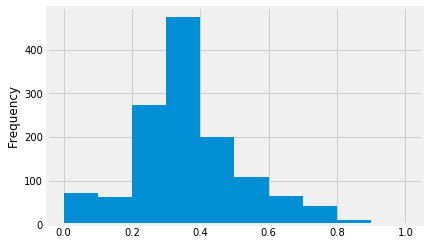

In [44]:
#注意：z-score,min-max这两种变换都是线性变换，不会改变分布形状
titanic_min_max_df['Age'].plot(kind='hist')

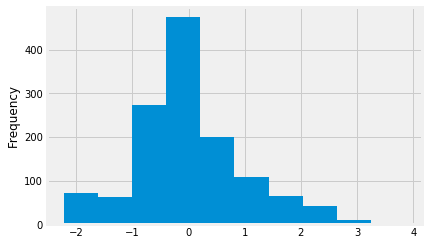

In [45]:
titanic_z_score_df['Age'].plot(kind='hist')

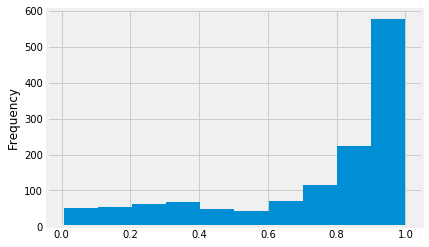

In [46]:
#行归一化会改变
titanic_normalize_df['Age'].plot(kind='hist')

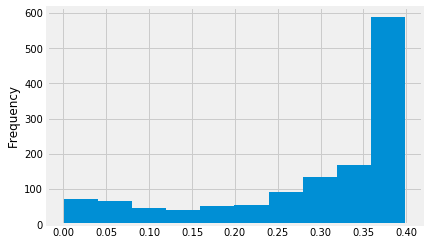

In [47]:
#pdf:标准正态分布的概率密度函数
from scipy.stats import norm
age_mean=features_df['Age'].mean()
age_std=features_df['Age'].std()
features_df['Age'].apply(lambda x:norm.pdf((x-age_mean)/age_std)).plot(kind='hist')

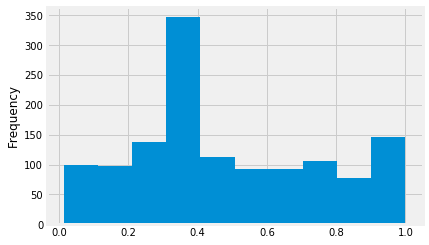

In [48]:
#cdf:分布函数
features_df['Age'].apply(lambda x:norm.cdf((x-age_mean)/age_std)).plot(kind='hist')

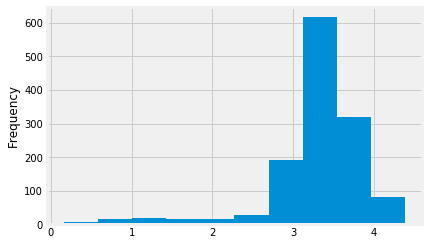

In [49]:
#log
features_df['Age'].apply(lambda x:np.log1p(x)).plot(kind='hist')

(array([ 51.,  35.,  48., 274., 478., 210., 118.,  55.,  32.,   8.]),
 array([-0.97171828,  2.70253966,  6.37679759, 10.05105553, 13.72531346,
        17.39957139, 21.07382933, 24.74808726, 28.42234519, 32.09660313,
        35.77086106]),
 <a list of 10 Patch objects>)

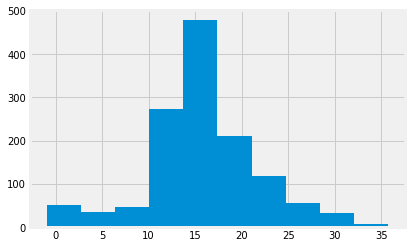

In [50]:
#boxcox
from scipy.stats import boxcox
plt.hist(boxcox(features_df['Age'])[0])

In [51]:
#最佳lambda
boxcox(features_df['Age'])[1]

0.7627222156380012

### 三.选择基准模型
（1）**目标**：本数据集是预测乘客是否存活，所以可以看做是分类任务；  
（2）**量化目标**：选择合适的评估指标，这里我们可以选择f1；  
（3）从分类模型中选择一个较优的模型作为基准模型，这是一个比较繁琐的工作；  

In [52]:
data_x=StandardScaler().fit_transform(features_df[:891])
#切分训练集测试集
X_train,X_test, y_train, y_test =train_test_split(data_x,labels,test_size=0.2, random_state=42)
#训练模型
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
#预测数据
y_predict=classifier.predict(X_test)
#查看检测指标
f1_score=metrics.f1_score(y_test,y_predict)
f1_score

0.7862068965517242

In [53]:
#为了结果更加客观，可以做k-fold交叉验证，但会更耗时

classifier=LogisticRegression()
scores = cross_val_score(classifier, data_x, labels, scoring='f1', cv = 5)#注意：f1只是看正样本的f1,如果要看整体的用f1_macro,但这一般会使得f1偏高
#查看均值与标准差,均值反映模型的预测能力，标准差可以反映模型的稳定性
np.mean(scores),np.std(scores)

(0.759262777574798, 0.016196297194678546)

In [54]:
#我们再看看另一种分类器
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7724798337990278, 0.052794300926641495)

#### 定位模型能力：方差与偏差
可以参考下面图为我们的模型做定位：  
![avatar](./source/方差与偏差.png)
来源:https://blog.csdn.net/hertzcat/article/details/80035330

#### 检查过/欠拟合情况
过/欠拟合可以通过模型在训练集/验证集/测试集上的表现来评估，  
（1）训练集/验证集/测试集效果都比较差，可以看作是欠拟合(除非训练数据真的是太差了)，这时可以增加模型的复杂度试一试；  
（2）训练集的表现好，而验证集/测试集的表现差，一般就是过拟合（这也是经常会遇到的问题），可以下面的一些方式常识：  
    2.1）降低模型复杂度：1.换更简单的模型，2.正则化技术  
    2.2）增强训练数据  

In [55]:
#查看lr的训练集，测试集的情况
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.7630057803468208 	 test: 0.7862068965517242


In [56]:
#查看gbdt的训练集，测试集的情况
classifier=GradientBoostingClassifier()
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.8641975308641976 	 test: 0.7826086956521738


可以发现gbdt有点过拟合了，lr很稳定，然后我们可以看出模型过拟合/欠拟合与模型方差/偏差的一些关系：  
（1）欠拟合模型往往偏差大（这里对应f1指标较小）  
（2）过拟合模型往往方差较大（这里对应f1的标准差较大）  
接下来可以通过降低gbdt中cart树数量的方式来降低模型复杂度：  

In [57]:
classifier=GradientBoostingClassifier(n_estimators=80)#默认是100
scores = cross_val_score(classifier, data_x, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7770062297307175, 0.04740066888740136)

In [58]:
classifier=GradientBoostingClassifier(n_estimators=80)
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.8588957055214724 	 test: 0.7769784172661871


### 四.优化
对于建模的优化，可以自然的从三方面来考虑：  
（1）特征优化：异常处理、扩展特征，特征选择，特征转换...  
（2）数据增强：过采样、根据数据特性造新数据、半监督学习...  
（3）模型优化：超参优化、模型集成...

#### 4.1.1 异常处理：盖帽
盖帽操作可以在一定程度上去掉一些异常点，从而提高模型的泛化能力

In [59]:
#将数值低于5%分位数的设置为5%分位数值，高于95%分位数的设置为95%分位数值
low_thresh=5
high_thresh=95
cap_dict={}
for column in features_df.columns:
    low_value=np.percentile(features_df[:891][column],low_thresh)
    high_value=np.percentile(features_df[:891][column],high_thresh)
    if low_value==high_value:#这里相当于不进行盖帽
        low_value=np.min(features_df[:891][column])
        high_value=np.max(features_df[:891][column])
    cap_dict[column]=[low_value,high_value]
#更新
def cap_update(column,x):
    if x>cap_dict[column][1]:
        return cap_dict[column][1]
    elif x<cap_dict[column][0]:
        return cap_dict[column][0]
    else:
        return x
for column in features_df.columns:
    features_df[column]=features_df[column].apply(lambda x:cap_update(column,x))

In [60]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7819874859401702, 0.036249676894704055)

可以发现盖帽处理直接将结果提升了差不多1%，而且模型的方差降低了不少，可以起到不错的泛化作用

#### 4.1.2 特征扩展：推理
凭借自己对数据的理解构建有意义的特征，比如：  
通过Cabin关联乘客的同行者的信息，根据前面的性别-存活率的热图，我们扩展这样的特征：是否有其他小孩(Age<=10), 是否有其他女性，是否有其他老人(age>=70),是否有其他青年男性（20<=Age<=50），以及当前cabin的人数

In [61]:
extend_df=origin_features_df[['PassengerId','Age','Sex','Name','Cabin']]
extend_df=extend_df[~extend_df['Cabin'].isnull()]

In [62]:
extend_df2=extend_df[['Age','Name','Sex','Cabin']]
extend_df2.columns=['Age2','Name2','Sex2','Cabin']

In [63]:
merge_df=pd.merge(extend_df,extend_df2,on='Cabin',how='left')

In [64]:
def check_has_other_child(name1,name2,age2):
    if name1==name2:
        return 0
    else:
        if age2<=10:
            return 1
        else:
            return 0
merge_df['Has_other_child']=merge_df.apply(lambda row:check_has_other_child(row['Name'],row['Name2'],row['Age2']),axis=1)

In [65]:
def check_has_other_female(name1,name2,sex2):
    if name1==name2:
        return 0
    else:
        if sex2=='female':
            return 1
        else:
            return 0
merge_df['Has_other_female']=merge_df.apply(lambda row:check_has_other_female(row['Name'],row['Name2'],row['Sex2']),axis=1)

In [66]:
def check_has_other_old(name1,name2,age2):
    if name1==name2:
        return 0
    else:
        if age2>=70:
            return 1
        else:
            return 0
merge_df['Has_other_old']=merge_df.apply(lambda row:check_has_other_old(row['Name'],row['Name2'],row['Age2']),axis=1)

In [67]:
def check_has_young_male(name1,name2,sex2,age2):
    if name1==name2:
        return 0
    else:
        if sex2=='male' and age2>=20 and age2<=50:
            return 1
        else:
            return 0
merge_df['Has_other_young_male']=merge_df.apply(lambda row:check_has_young_male(row['Name'],row['Name2'],row['Sex2'],row['Age2']),axis=1)

In [68]:
merge_df=merge_df[['PassengerId','Has_other_child','Has_other_female','Has_other_old','Has_other_young_male']]

In [69]:
#去重
gp_df=merge_df.groupby(by=['PassengerId']).agg({'Has_other_child':'max','Has_other_female':'max','Has_other_old':'max','Has_other_young_male':'max'}).reset_index()

In [70]:
gp_df.head(5)

,PassengerId,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,2,0,0,0,1
1,4,0,0,0,1
2,7,0,0,0,0
3,11,1,1,0,0
4,12,0,0,0,0


In [71]:
extend_df=pd.merge(origin_features_df[['PassengerId']],gp_df,on='PassengerId',how='left')
extend_df.fillna(0,inplace=True)

In [72]:
extend_df.head(5)

,PassengerId,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,1,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0
4,5,0.0,0.0,0.0,0.0


In [73]:
del extend_df['PassengerId']
features_df=pd.concat([features_df,extend_df],axis=1)

In [74]:
features_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,3,0,22.0,1.0,0.0,7.2500,0.299854,1,0,0,0.0,0.0,0.0,0.0
1,1,1,38.0,1.0,0.0,71.2833,0.383838,0,1,0,0.0,0.0,0.0,1.0
2,3,1,26.0,0.0,0.0,7.9250,0.299854,1,0,0,0.0,0.0,0.0,0.0
3,1,1,35.0,1.0,0.0,53.1000,0.468759,1,0,0,0.0,0.0,0.0,1.0
4,3,0,35.0,0.0,0.0,8.0500,0.299854,1,0,0,0.0,0.0,0.0,0.0


In [75]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7793257119630568, 0.04107771702611043)

#### 4.1.2 特征扩展：推理
之前我们删掉了Name，其实Name中的姓可以反应一些特征，比如Mrs可以放映出该乘客已经结婚，Miss表示未婚小姐姐，我们将其提取出来，另外SibSp表示乘客兄弟姐妹/配偶的个数，而Parch表示乘客父母/孩子的个数，可以简单相加表示他们的家庭成员多少，越多的存活率可能越高...  

更多:https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic

In [76]:
features_df['family_size']=features_df['SibSp']+features_df['Parch']+1

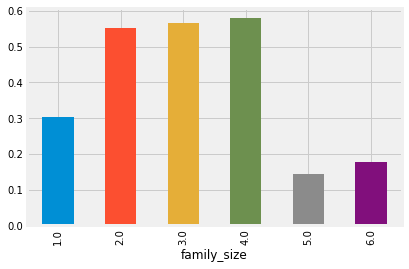

In [77]:
#统计存活率分布
show_df=features_df[:891]
show_df['Survived']=labels
show_df.groupby('family_size')['Survived'].mean().plot(kind='bar')

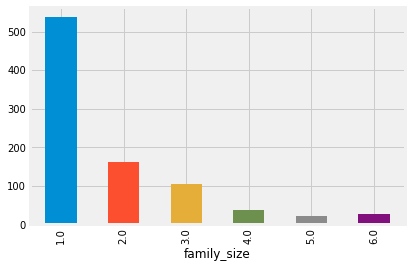

In [78]:
show_df.groupby('family_size')['Survived'].count().plot(kind='bar')

In [79]:
#提取姓名中的title
origin_features_df['Name'].apply(lambda name:name.split(',')[1].split('.')[0]).value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Major             2
 Ms                2
 Mlle              2
 the Countess      1
 Dona              1
 Don               1
 Jonkheer          1
 Sir               1
 Capt              1
 Mme               1
 Lady              1
Name: Name, dtype: int64

In [80]:
titles=['Mr','Miss','Mrs','Master']
def extract_title(name):
    for title in titles:
        if title in name:
            return title
    return 'Other'
features_df['name_title']=origin_features_df['Name'].apply(extract_title)

In [81]:
features_df=pd.get_dummies(features_df,columns=['name_title'])

In [82]:
features_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male,family_size,name_title_Master,name_title_Miss,name_title_Mr,name_title_Other
0,3,0,22.0,1.0,0.0,7.2500,0.299854,1,0,0,0.0,0.0,0.0,0.0,2.0,0,0,1,0
1,1,1,38.0,1.0,0.0,71.2833,0.383838,0,1,0,0.0,0.0,0.0,1.0,2.0,0,0,1,0
2,3,1,26.0,0.0,0.0,7.9250,0.299854,1,0,0,0.0,0.0,0.0,0.0,1.0,0,1,0,0
3,1,1,35.0,1.0,0.0,53.1000,0.468759,1,0,0,0.0,0.0,0.0,1.0,2.0,0,0,1,0
4,3,0,35.0,0.0,0.0,8.0500,0.299854,1,0,0,0.0,0.0,0.0,0.0,1.0,0,0,1,0


In [83]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7850367518401871, 0.04384734351577558)

#### 4.1.2 扩展特征：添加聚类标签
聚类标签可以看作是对目前样本的做的特征映射，将高维空间相似的特征映射到相同的标签；  
这里演示用kmean生成聚类标签，利用calinski_harabaz选择较优的k，  
更多：https://blog.csdn.net/u010159842/article/details/78624135

In [84]:
cluster_data_np=StandardScaler().fit_transform(features_df)

Text(0,0.5,'distortion degree')

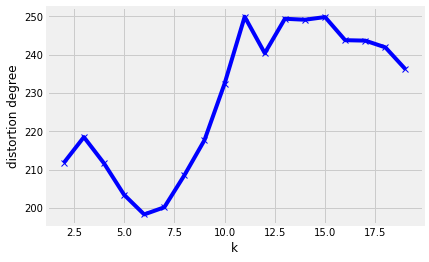

In [85]:
K=range(2,20)
calinski_harabaz_scores=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(cluster_data_np)
    calinski_harabaz_scores.append(metrics.calinski_harabaz_score(cluster_data_np, kmeans.predict(cluster_data_np)))
plt.plot(K,calinski_harabaz_scores,'bx-')
plt.xlabel('k')
plt.ylabel(u'distortion degree')

In [86]:
kmeans=KMeans(n_clusters=11)
kmeans.fit(cluster_data_np)
ext_cluster_fea_df=copy.deepcopy(features_df)
ext_cluster_fea_df['cluster_factor']=kmeans.predict(cluster_data_np)

In [87]:
ext_cluster_fea_dummy_df = pd.get_dummies(ext_cluster_fea_df,columns=['cluster_factor'])

In [88]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cluster_fea_dummy_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7805970033404762, 0.045626939881205225)

不过貌似这样选择的k做的聚类因子未必是最好的....可以多尝试几种...

#### 4.1.2  扩展特征：数值特征
对数值特征的扩展，可以考虑：  
（1）连续值分箱：某些特征分箱可能可以体现不一样的意义...  
（2）log变换等...改变原始数据的分布特性...  
（3）无脑构造多项式/交互特征：$[a,b]->[1,a,b,a^2,b^2,ab]$  
接下来试一试...

In [89]:
ext_fea_df=copy.deepcopy(ext_cluster_fea_dummy_df)
ext_fea_df['Age_bins']=pd.cut(ext_fea_df['Age'],bins=10,labels=False)#对age分箱
ext_fea_df['Fare_bins']=pd.cut(ext_fea_df['Fare'],bins=10,labels=False)#对Fare分箱
ext_fea_df['Age_log']=ext_fea_df['Age'].apply(lambda x:np.log1p(x))#log变换
ext_fea_df['Age_log_cdf']=ext_fea_df['Age_log'].apply(lambda x:norm.cdf((x-ext_fea_df['Age_log'].mean())/ext_fea_df['Age_log'].std()))#cdf变换

In [90]:
#lr
ext_fea_np=StandardScaler().fit_transform(ext_fea_df[:891])
classifier=LogisticRegression()
scores = cross_val_score(classifier, ext_fea_np, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7686322685829483, 0.03609935046387324)

In [91]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_fea_np, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7823895879512534, 0.04632164288132967)

In [92]:
#构造交互特征：一般来说选择0/1类型的特征来构造更make sense
poly=PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)#无脑多项式转换
poly_fea_np=poly.fit_transform(ext_fea_df)#这里是numpy类型
poly_fea_df=pd.DataFrame(poly_fea_np,columns=poly.get_feature_names())

**注意：构造多项式特征慎用，它以$O(n^2)$增涨特征量，如果原始有1000个特征，变换后会有100W个特征...**

In [93]:
poly_fea_df.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30^2,x30 x31,x30 x32,x30 x33,x31^2,x31 x32,x31 x33,x32^2,x32 x33,x33^2
0,3.0,0.0,22.0,1.0,0.0,7.2500,0.299854,1.0,0.0,0.0,...,9.0,0.0,9.406483,1.055688,0.0,0.000000,0.000000,9.831324,1.103368,0.123831
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.383838,0.0,1.0,0.0,...,36.0,36.0,21.981370,4.646550,36.0,21.981370,4.646550,13.421684,2.837154,0.599734
2,3.0,1.0,26.0,0.0,0.0,7.9250,0.299854,1.0,0.0,0.0,...,16.0,0.0,13.183347,1.942617,0.0,0.000000,0.000000,10.862541,1.600637,0.235860
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.468759,1.0,0.0,0.0,...,36.0,24.0,21.501114,4.317604,16.0,14.334076,2.878403,12.841608,2.578703,0.517825
4,3.0,0.0,35.0,0.0,0.0,8.0500,0.299854,1.0,0.0,0.0,...,36.0,0.0,21.501114,4.317604,0.0,0.000000,0.000000,12.841608,2.578703,0.517825


In [94]:
poly_fea_df.shape

(1309, 629)

In [95]:
#看看在lr上的表现
classifier=LogisticRegression()
scores = cross_val_score(classifier, StandardScaler().fit_transform(poly_fea_df[:891]), labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7529680759275237, 0.047662184324391406)

In [96]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, poly_fea_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7877111481159954, 0.043269962360609864)

###### 特征数增加是否会影响模型稳定性？
这里发现特征量的快速增加（10->629），lr的std增加了很多，gbdt有所减少，这是因为特征数量的增加被动的增加了lr模型的复杂度($\sigma(w^Tx+b)$,模型的复杂度与$x$的维度正比)，而gbdt在生成树的时候对于用处不大的特征，选择的少或者压根不会选。

#### 4.1.2 特征扩展：离散特征
离散特征的扩展可以考虑特征组合，比如：  
（1）从make sense的情况下组合特征；  
（2）自动特征组合...

#### make sense的特征
构造乘客性别和票类型的组合特征：

Pclass |  Sex  
-|-
1 | male |
2 | female |  
转换为：  

Pclass_1_female |  Pclass_2_female | Pclass_3_female |  Pclass_1_male |Pclass_2_male |  Pclass_3_male  
-|-|-|-|-|-
0|0|0|1|0|0
0|1|0|0|0|0 


In [97]:
def combine_pclass_sex(pclass,sex):
    if sex=='male':
        return pclass-1
    else:
        return pclass+2
ext_cat_fea_df=copy.deepcopy(poly_fea_df)
ext_cat_fea_df['Pclass_Sex']=origin_features_df.apply(lambda row:combine_pclass_sex(row['Pclass'],row['Sex']),axis=1)
ext_cat_fea_dummy_df = pd.get_dummies(ext_cat_fea_df,columns=['Pclass_Sex'])

In [98]:
ext_cat_fea_dummy_df.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x31 x33', 'x32^2', 'x32 x33', 'x33^2', 'Pclass_Sex_0', 'Pclass_Sex_1',
       'Pclass_Sex_2', 'Pclass_Sex_3', 'Pclass_Sex_4', 'Pclass_Sex_5'],
      dtype='object', length=635)

In [99]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cat_fea_dummy_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7875957671794318, 0.03422694316681235)

#### 4.1.2 特征扩展：自动构建组合特征
比较流行的一种方式是gbdt+lr,即利用gbdt探索不错的特征空间，然后用lr对这些特征空间张成one-hot特征进行拟合；  
![avatar](./source/gbdt_lr.png)
参考：https://www.cnblogs.com/wkang/p/9657032.html

In [100]:
from sklearn.preprocessing import OneHotEncoder
n_trees=100
tree_depth=2#树的深度不必太深
kfold= KFold(n_splits=5,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    gbm1 = GradientBoostingClassifier(n_estimators=n_trees,max_depth=tree_depth)
    gbm1.fit(X_train, y_train)
    train_new_feature = gbm1.apply(X_train)
    train_new_feature = train_new_feature.reshape(-1, n_trees)

    enc = OneHotEncoder()

    enc.fit(train_new_feature)

    # # # 每一个属性的最大取值数目
    # # print('每一个特征的最大取值数目:', enc.n_values_)
    # # print('所有特征的取值数目总和:', enc.n_values_.sum())

    train_new_feature2 = np.array(enc.transform(train_new_feature).toarray())

    #训练lr
    lr=LogisticRegression()
    lr.fit(train_new_feature2,y_train)
    #测试
    test_new_feature = gbm1.apply(X_test)
    test_new_feature = test_new_feature.reshape(-1, n_trees)
    test_new_feature2 = np.array(enc.transform(test_new_feature).toarray())

    y_predict=lr.predict(test_new_feature2)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7713015276197386, 0.034522977378099305)

**通过一系列的特征扩展，我们将baseline gbdt从f1=0.776,std=0.045提升到f1=0.790,std=0.037；此时的最优fetures为ext_cat_fea_dummy_df，接下来我们的目标是去掉那些噪声特征，利用尽可能少的特征去建模达到和之前模型一样的效果；**  
#### 4.1.3 特征选择
（1）基于统计：方差、相关性、gini、info gain、chi2    
（2）基于模型：RFE递归删减特征、训练基模型，选择权值系数较高的特征  

更多:https://www.jianshu.com/p/1c4ec02dd33f

##### 4.1.3 特征选择-方差
将方差较低的特征过滤掉

In [101]:
var_standard_df=StandardScaler().fit_transform(ext_cat_fea_dummy_df[:891])
VarianceThreshold(threshold=0.01).fit_transform(var_standard_df).shape

(891, 492)

In [102]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, VarianceThreshold(threshold=0.01).fit_transform(ext_cat_fea_dummy_df[:891]), labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7870500513055333, 0.041771813326123064)

##### 4.1.3 特征选择-相关性
选择与y标签相关性top的因子建模

In [103]:
ext_cat_fea_add_y_df=copy.deepcopy(ext_cat_fea_dummy_df[:891])
ext_cat_fea_add_y_df['Survived']=labels
ext_cat_fea_add_y_df.corr()['Survived'].abs().sort_values(ascending=False).head(5)

Survived    1.000000
x1 x32      0.545021
x1 x6       0.543980
x1          0.543351
x1^2        0.543351
Name: Survived, dtype: float64

In [104]:
#选择相关性>0.2的因子建模，注意要去掉Survived
highly_correlated_features = ext_cat_fea_add_y_df.columns[ext_cat_fea_add_y_df.corr()['Survived'].abs() > 0.1]
highly_correlated_features = highly_correlated_features.drop('Survived')
high_corr_features_df=ext_cat_fea_add_y_df[highly_correlated_features]

In [105]:
high_corr_features_df.shape

(891, 214)

In [106]:
high_corr_features_df.head(5)

,x0,x1,x4,x5,x6,x7,x8,x11,x13,x16,...,x27 x33,x30 x31,x31^2,x31 x32,x31 x33,Pclass_Sex_1,Pclass_Sex_2,Pclass_Sex_3,Pclass_Sex_4,Pclass_Sex_5
0,3.0,0.0,0.0,7.2500,0.299854,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0,1,0,0,0
1,1.0,1.0,0.0,71.2833,0.383838,0.0,1.0,0.0,1.0,0.0,...,0.774425,36.0,36.0,21.981370,4.646550,0,0,1,0,0
2,3.0,1.0,0.0,7.9250,0.299854,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.0,0.0,0.000000,0.000000,0,0,0,0,1
3,1.0,1.0,0.0,53.1000,0.468759,1.0,0.0,0.0,1.0,0.0,...,0.719601,24.0,16.0,14.334076,2.878403,0,0,1,0,0
4,3.0,0.0,0.0,8.0500,0.299854,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0,1,0,0,0


In [107]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, high_corr_features_df, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.789829696982462, 0.0483977829936617)

**注意：如果出现与y标签相关性很高的因子要引起重视，它可能是由y=>的因子，这种情况应该删掉，因为在test集中这部分因子可能是NaN**
##### 4.1.3 特征选择-Gini指数
gini指数的计算很简单，训练一个决策树就好了

In [108]:
tree = DecisionTreeClassifier()#如果要用信息增益，设置criterion='entropy'
tree.fit(ext_cat_fea_dummy_df[:891],labels)
importances = pd.DataFrame({ 'feature':ext_cat_fea_dummy_df.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)

In [109]:
importances.head()

,feature,importance
81,x1 x14,0.308042
41,x0 x7,0.081556
6,x6,0.060521
438,x14 x33,0.053993
222,x5 x33,0.030702


In [110]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cat_fea_dummy_df[:891][select_features], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7993443854210763, 0.05081475219128071)

##### 4.1.3-chi2选择

In [111]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [112]:
min_max_standard_df=MinMaxScaler().fit_transform(ext_cat_fea_dummy_df[:891])#chi2要求每一项都>0

In [113]:
#选择前50个特征
top_50_features=SelectKBest(chi2, k=50).fit_transform(min_max_standard_df, labels)

In [114]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, top_50_features, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7547838029844384, 0.0382334783823522)

##### 4.1.3-RFE递归消除

In [115]:
# from sklearn.feature_selection import RFE
# rfe_df=RFE(estimator=GradientBoostingClassifier(), n_features_to_select=50).fit_transform(ext_cat_fea_dummy_df[:891], labels)

**这里相当的慢**

In [116]:
# #gbdt
# classifier=GradientBoostingClassifier()
# scores = cross_val_score(classifier, rfe_df, labels, scoring='f1', cv = 5)
# np.mean(scores),np.std(scores)

#### 4.1.3-基于模型选特征
其实这里和gini系数的选择一样，通过训练一个模型来选择特征最优特征，然后再去训练一个模型，只是这里选择特征用的模型与训练用的模型一样

In [117]:
#也可以直接用我们gbdt筛选后的特征
tree = GradientBoostingClassifier()
tree.fit(ext_cat_fea_dummy_df[:891],labels)
importances = pd.DataFrame({ 'feature':ext_cat_fea_dummy_df.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
importances.head()

,feature,importance
73,x1 x6,0.143721
35,x0 x1,0.119379
72,x1 x5,0.069650
41,x0 x7,0.061407
6,x6,0.047584


In [118]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
features_select_top_50_df=ext_cat_fea_dummy_df[select_features]
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.8000794313188381, 0.06017298725378909)

也可以使用SelectFromModel自动选择最优的top n因子

In [119]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
top_nums=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    select_feature_model = SelectFromModel(GradientBoostingClassifier())
    X_new_train=select_feature_model.fit_transform(X_train,y_train)
    
    X_new_test=select_feature_model.transform(X_test)
    
    _,top_num=X_new_test.shape
    top_nums.append(top_num)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7907252589751879, 0.05549700964161168)

In [120]:
np.mean(top_nums)

63.8

##### **注意：之前的特征选择操作都不太严谨，因为是将训练集和验证集合并在一起做的特征选择，再用cv的方式看一下**

In [121]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    tree = GradientBoostingClassifier()
    tree.fit(X_train,y_train)
    importances = pd.DataFrame({ 'feature':X_train.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
    
    select_features=importances['feature'].tolist()[:50]
    
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_train[select_features],y_train)
    y_predict=gbdt.predict(X_test[select_features])
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7853628345234904, 0.054688358631340604)

发现其实只需要1/10的因子就能达到和之前一样的效果，甚至更好....  

#### 4.1.4 特征转换
特征选择是从当前的特征集中选择一个子集，而特征转换是对feature/feature和label做某些数学操作，转换后的特征不在是之前特征的子集，比如：  
（1）pca:主成分分析；  
（2）lda:线性判别分析；  
（3）lle:局部线性嵌入；  
（4）ae:自编码；
（5）vae:变分自编码；

##### 4.1.4-pca
pca是一种无监督的线性降维方式，它构建了一个新的正交坐标系，相应的坐标轴分别叫“第一主成分”，“第二主成分”...，且数据在“第一主成分”坐标轴上**方差**最大，“第二主成分”其次，...通常可以只取前n个主成分，将方差较小的主成分理解为**噪声**；  
![avatar](./source/pca示例.png)
更多：https://blog.csdn.net/program_developer/article/details/80632779 

In [122]:
from sklearn.decomposition import PCA
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_pca=PCA(n_components=20).fit_transform(standard_df)

In [123]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7900949253855687, 0.035405470298260994)

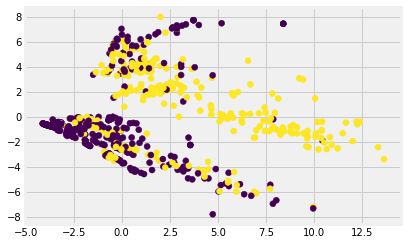

In [124]:
plt.scatter(X_pca[:891][:, 0], X_pca[:891][:, 1],marker='o',c=labels)
plt.show()

#### 4.1.4-lda
lda是一种线性的有监督降维方式，与pca的最大化方差的目标不同，它的目标是找到这样的新坐标轴：**同类样例的投影尽可能近，异类样例的投影点尽可能远**；  
更多：https://blog.csdn.net/weixin_40604987/article/details/79615968

In [125]:
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
standard_np=StandardScaler().fit_transform(features_select_top_50_df)
for train_index,test_index in kfold.split(standard_np[:891],labels):
    X_train=standard_np[train_index]
    y_train=labels[train_index]
    X_test=standard_np[test_index]
    y_test=labels[test_index]
    
    lda=LinearDiscriminantAnalysis(n_components=20)
    lda.fit(X_train, y_train)
    
    X_new_train=lda.transform(X_train)
    X_new_test=lda.transform(X_test)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7569760200754199, 0.0505068477051737)

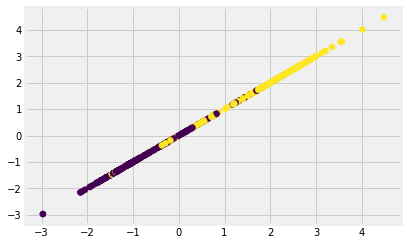

In [126]:
plt.scatter(X_new_train[:891][:, 0], X_new_train[:891][:, 0],marker='o',c=y_train)
plt.show()

#### 4.1.4 lle-局部线性嵌入（LocallyLinearEmbedding）
降维时保持样本局部的线性特征
![avatar](./source/lle示例.jpg)
更多：https://www.cnblogs.com/pinard/p/6266408.html?utm_source=itdadao&utm_medium=referral

In [127]:
from sklearn.manifold import LocallyLinearEmbedding
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_lle=LocallyLinearEmbedding(n_components=20).fit_transform(standard_df)

In [128]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_lle[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7460614383554046, 0.048413373247755194)

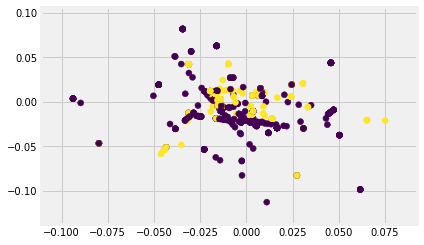

In [129]:
plt.scatter(X_lle[:891][:, 0], X_lle[:891][:, 1],marker='o',c=labels)
plt.show()

#### 4.1.4 ae-自编码
预测目标就是输入目标，可以把它看做一个压缩和解压的过程，如下，通过encoder把一个高维的数据压缩为低维的数据，通过decoder将低维数据还原为高维的数据，这样这个低维的数据可以看做高维数据的一种“不失真”表示；    
![avatar](./source/ae示例.jpg)
ae在图像和nlp方面都有很多深入的应用，比如cv中的vae，nlp中的bert等...  
更多：https://blog.csdn.net/leida_wt/article/details/85052299

In [130]:
from keras.models import Model
from keras.layers import *
# 指定显卡
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# 动态申请显存
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # 不全部占满显存, 按需分配
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


In [131]:
#定义网络结构
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(2,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

In [132]:
#预处理输入数据
ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df)

In [133]:
X_train=ae_standard_np[:1200]
X_eval=ae_standard_np[1200:]

In [134]:
X_train.shape,X_eval.shape

((1200, 50), (109, 50))

In [135]:
#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])

Train on 1200 samples, validate on 109 samples
Epoch 1/200
1200/1200 [==============================] - 1s 431us/step - loss: 1.0197 - val_loss: 1.0672
Epoch 2/200
1200/1200 [==============================] - 0s 26us/step - loss: 1.0076 - val_loss: 1.0549
Epoch 3/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.9979 - val_loss: 1.0463
Epoch 4/200
1200/1200 [==============================] - 0s 31us/step - loss: 0.9906 - val_loss: 1.0395
Epoch 5/200
1200/1200 [==============================] - 0s 30us/step - loss: 0.9843 - val_loss: 1.0336
Epoch 6/200
1200/1200 [==============================] - ETA: 0s - loss: 1.072 - 0s 25us/step - loss: 0.9777 - val_loss: 1.0273
Epoch 7/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.9709 - val_loss: 1.0201
Epoch 8/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.9629 - val_loss: 1.0119
Epoch 9/200
1200/1200 [==============================] - 0s 32us/step - loss: 0.9538 - val_loss:

Epoch 78/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.6182 - val_loss: 0.6565
Epoch 79/200
1200/1200 [==============================] - 0s 28us/step - loss: 0.6174 - val_loss: 0.6556
Epoch 80/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.6166 - val_loss: 0.6546
Epoch 81/200
1200/1200 [==============================] - 0s 35us/step - loss: 0.6159 - val_loss: 0.6539
Epoch 82/200
1200/1200 [==============================] - 0s 34us/step - loss: 0.6152 - val_loss: 0.6530
Epoch 83/200
1200/1200 [==============================] - 0s 37us/step - loss: 0.6145 - val_loss: 0.6522
Epoch 84/200
1200/1200 [==============================] - 0s 31us/step - loss: 0.6138 - val_loss: 0.6518
Epoch 85/200
1200/1200 [==============================] - 0s 29us/step - loss: 0.6131 - val_loss: 0.6513
Epoch 86/200
1200/1200 [==============================] - 0s 32us/step - loss: 0.6125 - val_loss: 0.6506
Epoch 87/200
1200/1200 [==============================]

1200/1200 [==============================] - 0s 24us/step - loss: 0.5919 - val_loss: 0.6319
Epoch 156/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.5918 - val_loss: 0.6318
Epoch 157/200
1200/1200 [==============================] - 0s 26us/step - loss: 0.5916 - val_loss: 0.6316
Epoch 158/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.5915 - val_loss: 0.6314
Epoch 159/200
1200/1200 [==============================] - 0s 32us/step - loss: 0.5914 - val_loss: 0.6314
Epoch 160/200
1200/1200 [==============================] - 0s 31us/step - loss: 0.5913 - val_loss: 0.6316
Epoch 161/200
1200/1200 [==============================] - 0s 31us/step - loss: 0.5912 - val_loss: 0.6311
Epoch 162/200
1200/1200 [==============================] - 0s 29us/step - loss: 0.5911 - val_loss: 0.6309
Epoch 163/200
1200/1200 [==============================] - 0s 28us/step - loss: 0.5909 - val_loss: 0.6306
Epoch 164/200
1200/1200 [==============================] - 0

In [136]:
X_eval[0]

array([ 0.82766931,  1.93572254,  0.0336646 ,  1.07885292, -0.37019258,
        1.49602053,  0.96276563,  1.25937023, -0.22643032,  1.34499549,
        2.35787478, -0.51502135,  2.56645764,  2.24948554,  1.17060062,
       -0.3250884 , -0.36321285, -0.39213719,  0.6212742 ,  1.06873154,
       -0.18490606,  1.10470414, -0.08773955, -0.35177719,  0.87936559,
        0.55780901, -0.14069042, -0.14198762,  2.42674631, -0.12079052,
       -0.77146693, -0.12027696, -0.17571017,  1.34499549, -0.44771505,
       -0.10208177, -0.19266846,  1.67113775,  0.54501064, -0.47507471,
       -0.12027696, -0.32342025,  2.25917848, -0.29429097, -0.31815144,
       -0.24310938, -0.25669649, -0.34643049, -0.05251453, -0.44281517])

In [137]:
model.predict(X_eval)[0]

array([ 0.84259963,  0.89565194, -0.1657296 ,  0.3699348 , -0.46292907,
        0.74069   ,  0.52614015, -0.3312198 , -0.6547402 ,  0.8768692 ,
        0.8939867 , -0.9338216 ,  0.55263174,  0.7648835 , -0.33672792,
       -0.41581   , -0.5297965 , -0.6790321 ,  0.6871953 ,  0.1279342 ,
       -0.6482408 , -0.19741514,  0.01378946,  0.31400046,  0.7704295 ,
       -0.21264473, -0.5385604 , -0.50612307,  0.46878704, -0.632584  ,
       -0.9613648 , -0.1219368 , -0.03166279,  0.8712636 , -0.60364246,
        0.07714609, -0.6353725 ,  0.9529996 ,  0.25829062, -0.6812642 ,
       -0.12176671,  0.2922581 ,  0.8147812 ,  0.16231813, -0.10317522,
       -0.35576746,  0.08484281, -0.15319254,  0.03710562, -0.6286148 ],
      dtype=float32)

In [138]:
encode_layer_model.predict(X_eval)[0]

array([1.7635584, 0.       ], dtype=float32)

In [139]:
np.mean(X_eval-model.predict(X_eval)),np.std(X_eval-model.predict(X_eval))

(0.08181091146516974, 0.7877961965753176)

In [140]:
ae_new_features=encode_layer_model.predict(ae_standard_np)

In [141]:
ae_new_features.shape

(1309, 2)

In [142]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.6780143813765033, 0.017743977525973863)

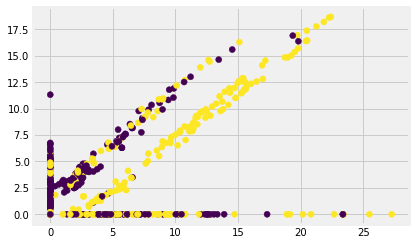

In [143]:
plt.scatter(ae_new_features[:891][:, 0], ae_new_features[:891][:, 1],marker='o',c=labels)
plt.show()

#### 4.1.4 vae-变分自编码
变分自编码即在中间添加白噪声，增强自编码的泛化能力  
更多：https://blog.csdn.net/weixin_41923961/article/details/81586082

In [144]:
#定义网络结构
from keras import backend as K
from keras import objectives
latent_dim = 2
intermediate_dim = 32
epsilon_std = 1.0

x = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
 
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
 
#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = input_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [145]:
vae.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])

Train on 1200 samples, validate on 109 samples
Epoch 1/200
1200/1200 [==============================] - 0s 385us/step - loss: 36.0322 - val_loss: 34.7021
Epoch 2/200
1200/1200 [==============================] - 0s 46us/step - loss: 33.8301 - val_loss: 31.6163
Epoch 3/200
1200/1200 [==============================] - 0s 41us/step - loss: 32.4203 - val_loss: 32.2834
Epoch 4/200
1200/1200 [==============================] - 0s 40us/step - loss: 29.9816 - val_loss: 30.0823
Epoch 5/200
1200/1200 [==============================] - 0s 44us/step - loss: 26.8610 - val_loss: 26.0733
Epoch 6/200
1200/1200 [==============================] - 0s 46us/step - loss: 23.5636 - val_loss: 25.6523
Epoch 7/200
1200/1200 [==============================] - 0s 44us/step - loss: 18.2856 - val_loss: 9.0534
Epoch 8/200
1200/1200 [==============================] - 0s 44us/step - loss: 11.1824 - val_loss: 6.3278
Epoch 9/200
1200/1200 [==============================] - 0s 42us/step - loss: 6.7168 - val_loss: 4.9056
Ep

Epoch 75/200
1200/1200 [==============================] - 0s 42us/step - loss: -232.7775 - val_loss: -231.3263
Epoch 76/200
1200/1200 [==============================] - 0s 43us/step - loss: -233.9794 - val_loss: -231.1739
Epoch 77/200
1200/1200 [==============================] - 0s 37us/step - loss: -233.5089 - val_loss: -233.4069
Epoch 78/200
1200/1200 [==============================] - 0s 41us/step - loss: -233.5800 - val_loss: -230.3409
Epoch 79/200
1200/1200 [==============================] - 0s 42us/step - loss: -234.5334 - val_loss: -234.8030
Epoch 80/200
1200/1200 [==============================] - 0s 43us/step - loss: -235.5616 - val_loss: -235.6455
Epoch 81/200
1200/1200 [==============================] - 0s 39us/step - loss: -236.4999 - val_loss: -235.4594
Epoch 82/200
1200/1200 [==============================] - 0s 37us/step - loss: -237.3346 - val_loss: -235.1954
Epoch 83/200
1200/1200 [==============================] - 0s 38us/step - loss: -237.3713 - val_loss: -237.6295
E

1200/1200 [==============================] - 0s 48us/step - loss: -256.6824 - val_loss: -256.7156
Epoch 149/200
1200/1200 [==============================] - 0s 40us/step - loss: -255.9437 - val_loss: -256.4921
Epoch 150/200
1200/1200 [==============================] - 0s 40us/step - loss: -256.3107 - val_loss: -257.5755
Epoch 151/200
1200/1200 [==============================] - 0s 37us/step - loss: -255.9291 - val_loss: -257.0658
Epoch 152/200
1200/1200 [==============================] - 0s 40us/step - loss: -257.1780 - val_loss: -257.6051
Epoch 153/200
1200/1200 [==============================] - 0s 39us/step - loss: -257.3651 - val_loss: -257.7213
Epoch 154/200
1200/1200 [==============================] - 0s 43us/step - loss: -258.1064 - val_loss: -256.3364
Epoch 155/200
1200/1200 [==============================] - 0s 41us/step - loss: -256.5212 - val_loss: -257.9618
Epoch 156/200
1200/1200 [==============================] - 0s 41us/step - loss: -257.5103 - val_loss: -259.6528
Epoch 

In [146]:
encoder = Model(x, z_mean)

In [147]:
ae_new_features=encoder.predict(ae_standard_np)

In [148]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.6989266662463456, 0.03092964026276171)

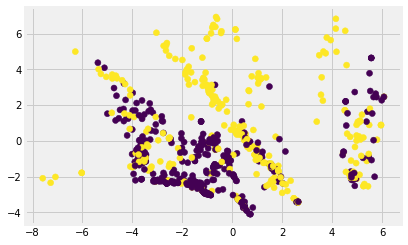

In [149]:
plt.scatter(ae_new_features[:891][:, 0], ae_new_features[:891][:, 1],marker='o',c=labels)
plt.show()

添加白噪声数据进行正则化后，更容易将数据分散开

##### 特征增强总结
特征增强很关键，是后续操作的基础，其实最有用的在于造出make sense的特征，从之前的操作来看我们造了几个make sense的特征就立即把模型从0.77+提升到了0.78+，而通过后续一系列的复杂特征变换（聚类、交互特征、特征选择...）才从0.78+提升到0.79+，接下来我们在features_select_top_50_df基础上尝试一些数据增强的方式；  

#### 4.2 数据增强
提供更多数据给模型训练，可从两方面来考虑：  

（1）利用其余的未标记数据进行无监督学习，在我们的标记数据进行监督学习（半监督学习），比如nlp任务中收集海量的文本数据训练embedding，然后再在其他nlp任务上做fine tuning；  
（2）在当前数据的基础上造出相似的数据，比如nlp任务中删除某一个词、替换同义词...，cv任务中缩放、旋转、翻转图片、gan...

##### 4.2.1 数据增强-半监督学习
这里没有多余的feature数据，我们假设test部分就是多出来的部分；  

在pca上做对比...

In [150]:
#增强前
standard_df=StandardScaler().fit_transform(features_select_top_50_df[:891])
X_pca=PCA(n_components=20).fit_transform(standard_df)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7791925787728027, 0.03804481662137799)

In [151]:
#增强后
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_pca=PCA(n_components=20).fit_transform(standard_df)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7915154050620196, 0.03498963750537092)

在ae上对比...

In [152]:
#增强前
#定义网络结构
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(20,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df[:891])
X_train=ae_standard_np[:750]
X_eval=ae_standard_np[750:]

#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])
ae_new_features=encode_layer_model.predict(ae_standard_np)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

Train on 750 samples, validate on 141 samples
Epoch 1/200
750/750 [==============================] - 0s 375us/step - loss: 1.1590 - val_loss: 1.1222
Epoch 2/200
750/750 [==============================] - 0s 44us/step - loss: 1.1042 - val_loss: 1.0713
Epoch 3/200
750/750 [==============================] - 0s 43us/step - loss: 1.0534 - val_loss: 1.0264
Epoch 4/200
750/750 [==============================] - 0s 40us/step - loss: 1.0071 - val_loss: 0.9862
Epoch 5/200
750/750 [==============================] - 0s 31us/step - loss: 0.9651 - val_loss: 0.9490
Epoch 6/200
750/750 [==============================] - 0s 31us/step - loss: 0.9265 - val_loss: 0.9132
Epoch 7/200
750/750 [==============================] - 0s 32us/step - loss: 0.8904 - val_loss: 0.8790
Epoch 8/200
750/750 [==============================] - 0s 31us/step - loss: 0.8560 - val_loss: 0.8464
Epoch 9/200
750/750 [==============================] - 0s 33us/step - loss: 0.8230 - val_loss: 0.8151
Epoch 10/200
750/750 [=============

750/750 [==============================] - 0s 32us/step - loss: 0.3950 - val_loss: 0.4177
Epoch 81/200
750/750 [==============================] - 0s 33us/step - loss: 0.3945 - val_loss: 0.4170
Epoch 82/200
750/750 [==============================] - 0s 37us/step - loss: 0.3938 - val_loss: 0.4163
Epoch 83/200
750/750 [==============================] - 0s 33us/step - loss: 0.3933 - val_loss: 0.4157
Epoch 84/200
750/750 [==============================] - 0s 28us/step - loss: 0.3927 - val_loss: 0.4151
Epoch 85/200
750/750 [==============================] - 0s 33us/step - loss: 0.3921 - val_loss: 0.4144
Epoch 86/200
750/750 [==============================] - 0s 32us/step - loss: 0.3916 - val_loss: 0.4139
Epoch 87/200
750/750 [==============================] - 0s 36us/step - loss: 0.3910 - val_loss: 0.4133
Epoch 88/200
750/750 [==============================] - 0s 35us/step - loss: 0.3905 - val_loss: 0.4126
Epoch 89/200
750/750 [==============================] - 0s 33us/step - loss: 0.3900 - 

750/750 [==============================] - 0s 40us/step - loss: 0.3699 - val_loss: 0.3910
Epoch 159/200
750/750 [==============================] - 0s 43us/step - loss: 0.3697 - val_loss: 0.3908
Epoch 160/200
750/750 [==============================] - 0s 36us/step - loss: 0.3696 - val_loss: 0.3906
Epoch 161/200
750/750 [==============================] - 0s 31us/step - loss: 0.3694 - val_loss: 0.3905
Epoch 162/200
750/750 [==============================] - 0s 32us/step - loss: 0.3692 - val_loss: 0.3904
Epoch 163/200
750/750 [==============================] - 0s 33us/step - loss: 0.3691 - val_loss: 0.3902
Epoch 164/200
750/750 [==============================] - 0s 28us/step - loss: 0.3689 - val_loss: 0.3900
Epoch 165/200
750/750 [==============================] - 0s 28us/step - loss: 0.3688 - val_loss: 0.3898
Epoch 166/200
750/750 [==============================] - 0s 33us/step - loss: 0.3686 - val_loss: 0.3897
Epoch 167/200
750/750 [==============================] - 0s 35us/step - loss: 

(0.7752863876311468, 0.04550175059993495)

In [153]:
#增强后
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(20,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df)
X_train=ae_standard_np[:1200]
X_eval=ae_standard_np[1200:]

#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])
ae_new_features=encode_layer_model.predict(ae_standard_np)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

Train on 1200 samples, validate on 109 samples
Epoch 1/200
1200/1200 [==============================] - 0s 274us/step - loss: 1.1714 - val_loss: 1.1603
Epoch 2/200
1200/1200 [==============================] - 0s 27us/step - loss: 1.0831 - val_loss: 1.0879
Epoch 3/200
1200/1200 [==============================] - 0s 29us/step - loss: 1.0114 - val_loss: 1.0262
Epoch 4/200
1200/1200 [==============================] - 0s 35us/step - loss: 0.9489 - val_loss: 0.9699
Epoch 5/200
1200/1200 [==============================] - 0s 42us/step - loss: 0.8911 - val_loss: 0.9141
Epoch 6/200
1200/1200 [==============================] - 0s 29us/step - loss: 0.8366 - val_loss: 0.8592
Epoch 7/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.7843 - val_loss: 0.8059
Epoch 8/200
1200/1200 [==============================] - 0s 33us/step - loss: 0.7343 - val_loss: 0.7563
Epoch 9/200
1200/1200 [==============================] - 0s 26us/step - loss: 0.6885 - val_loss: 0.7123
Epoch 10/200
120

1200/1200 [==============================] - 0s 31us/step - loss: 0.3808 - val_loss: 0.4079
Epoch 79/200
1200/1200 [==============================] - 0s 28us/step - loss: 0.3804 - val_loss: 0.4073
Epoch 80/200
1200/1200 [==============================] - 0s 25us/step - loss: 0.3799 - val_loss: 0.4068
Epoch 81/200
1200/1200 [==============================] - 0s 30us/step - loss: 0.3795 - val_loss: 0.4064
Epoch 82/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.3791 - val_loss: 0.4059
Epoch 83/200
1200/1200 [==============================] - 0s 30us/step - loss: 0.3787 - val_loss: 0.4053
Epoch 84/200
1200/1200 [==============================] - 0s 31us/step - loss: 0.3784 - val_loss: 0.4048
Epoch 85/200
1200/1200 [==============================] - 0s 29us/step - loss: 0.3780 - val_loss: 0.4044
Epoch 86/200
1200/1200 [==============================] - 0s 32us/step - loss: 0.3776 - val_loss: 0.4038
Epoch 87/200
1200/1200 [==============================] - 0s 27us/st

Epoch 155/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.3638 - val_loss: 0.3888
Epoch 156/200
1200/1200 [==============================] - 0s 29us/step - loss: 0.3637 - val_loss: 0.3886
Epoch 157/200
1200/1200 [==============================] - 0s 26us/step - loss: 0.3636 - val_loss: 0.3886
Epoch 158/200
1200/1200 [==============================] - 0s 26us/step - loss: 0.3635 - val_loss: 0.3886
Epoch 159/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.3634 - val_loss: 0.3884
Epoch 160/200
1200/1200 [==============================] - 0s 27us/step - loss: 0.3633 - val_loss: 0.3884
Epoch 161/200
1200/1200 [==============================] - 0s 28us/step - loss: 0.3632 - val_loss: 0.3883
Epoch 162/200
1200/1200 [==============================] - 0s 30us/step - loss: 0.3631 - val_loss: 0.3882
Epoch 163/200
1200/1200 [==============================] - 0s 24us/step - loss: 0.3630 - val_loss: 0.3881
Epoch 164/200
1200/1200 [=====================

(0.7675414890194835, 0.033262851771355864)

另外，对NaN的填充，仅用训练数据和用增强后的数据也可以做对比.....

##### 4.2.2 数据增强-过采样
这里推荐imblearn工具  
pip install imblearn

In [154]:
from imblearn.over_sampling import SMOTE
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(features_select_top_50_df[:891],labels):
    X_train=features_select_top_50_df.loc[train_index]
    y_train=labels[train_index]
    X_test=features_select_top_50_df.loc[test_index]
    y_test=labels[test_index]
    
    X_resampled,y_resampled=SMOTE(k_neighbors=5).fit_sample(X_train,y_train)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_resampled,y_resampled)
    y_predict=gbdt.predict(X_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.8023959131004276, 0.05676594835661363)

##### 4.2.2 数据增强-自定义规则
对每条训练数据做如下操作：  
（1）随机删掉某个特征（0替换）；  
（2）随机交换同class的某个特征的值；  
（3）随机交换非class的某个特征的值；  

In [155]:
def extend_data(train_df,train_y):
    #删除操作
    rows,cols=train_df.shape
    delete_df=copy.deepcopy(train_df)
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        delete_df.iloc[i,j]=0#注意：要用iloc[i,j]的方式才能成功赋值，loc[i,j],iloc[i][j],iloc[i,j]的方式都不行
    #替换操作
    replace_df=copy.deepcopy(train_df)
    zero_class_df=train_df[train_y==0]
    one_class_df=train_df[train_y==1]
    zero_rows,_=zero_class_df.shape
    one_rows,_=one_class_df.shape
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        if train_y.tolist()[i]==0:
            new_i=random.choice(range(0,zero_rows))
            replace_df.iloc[i,j]=zero_class_df.iloc[new_i,j]
        else:
            new_i=random.choice(range(0,one_rows))
            replace_df.iloc[i,j]=one_class_df.iloc[new_i,j]
    #替换操作
    replace_df2=copy.deepcopy(train_df)
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        if train_y.tolist()[i]==0:
            new_i=random.choice(range(0,one_rows))
            replace_df2.iloc[i,j]=one_class_df.iloc[new_i,j]
        else:
            new_i=random.choice(range(0,zero_rows))
            replace_df2.iloc[i,j]=zero_class_df.iloc[new_i,j]
    #合并
    return pd.concat([train_df,delete_df,replace_df,replace_df2]),train_y.tolist()*4

In [156]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(features_select_top_50_df[:891],labels):
    X_train=features_select_top_50_df.loc[train_index]
    y_train=labels[train_index]
    X_test=features_select_top_50_df.loc[test_index]
    y_test=labels[test_index]
    
    X_extended,y_extended=extend_data(X_train,y_train)
    X_extended2,y_extended2=extend_data(X_train,y_train)
    X_extended3,y_extended3=extend_data(X_train,y_train)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(pd.concat([X_train,X_extended,X_extended2,X_extended3]),y_train.tolist()+y_extended+y_extended2+y_extended3)
    y_predict=gbdt.predict(X_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.8050731990298431, 0.05334388437545418)

这里把数据扩了12倍，多次运行，绝大部分情况下f1>0.8，当然，我们也可以与过采样的方法结合起来

#### 4.3模型优化  
模型的优化，可以考虑：  
（1）单模型优化：超参搜索；  
（2）多模型集成：集成学习；  

##### 4.3.1 超参数搜索
超参是指需要人为设定的参数，比如前面gbdt中的```n_estimators,max_depth,learning_rate```等；目前常见的超参搜索有网格搜索、随机搜索、贝叶斯优化搜索，还有基于强化学习的，比如google vizier...，其实比较好的方法是“人工智能”搜索（只需要一个excel表，并记录到相关操作对结果的改变就好了<坏结果也要保留>），接下来我们就在features_select_top_50_df数据集以及gbdt模型的基础上演示网格搜索、随机搜索、贝叶斯搜索...

##### 4.3.1 超参数搜索-网格搜索
网格搜索是将超参搜索空间切分成许多网格，我们在这些交点上选择一个较优秀的超参，但由于优化目标往往非凸，最优参数往往会成为漏网之鱼，通常比较建议的一种方式是在大范围内进行初步搜索，然后再在小范围内精确搜索。

In [157]:
from sklearn.model_selection import GridSearchCV
#定义搜索空间
gdbt_parameters = {'max_depth': [3,4,5],'learning_rate':[0.1,0.15,0.2],'n_estimators':[50,80,100,150]}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
grid = GridSearchCV(gbdt, gdbt_parameters,scoring='f1')
grid.fit(features_select_top_50_df[:891], labels)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.15, 0.2], 'n_estimators': [50, 80, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [158]:
grid.best_score_

0.7913674844734889

In [159]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [160]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=80,max_depth=3,learning_rate=0.15)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.8049563435310698, 0.04026419511814796)

##### 4.3.1超参数搜索-随机搜索
更多：https://blog.csdn.net/qq_36810398/article/details/86699842

In [161]:
from sklearn.model_selection import RandomizedSearchCV
#定义搜索空间
gdbt_parameters = {'max_depth': [3,4,5],'learning_rate':[0.1,0.15,0.2],'n_estimators':[50,80,100,150]}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
random_search = RandomizedSearchCV(gbdt, gdbt_parameters,scoring='f1')
random_search.fit(features_select_top_50_df[:891], labels)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.15, 0.2], 'n_estimators': [50, 80, 100, 150]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [162]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.15}

In [163]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=80,max_depth=3,learning_rate=0.1)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7953503302636137, 0.05131962771636548)

#### 4.3.1超参数搜索-贝叶斯优化
这里推荐使用Hyperopt工具  
更多：https://www.jianshu.com/p/35eed1567463

In [164]:
from hyperopt import fmin, tpe, hp,STATUS_OK,Trials

#定义loss函数
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    return cross_val_score(clf, features_select_top_50_df[:891],labels,cv=5,scoring='f1').mean()
#定义搜索空间
space4gbdt = {
    'max_depth': hp.choice('max_depth', [3,4,5]),
    'n_estimators': hp.choice('n_estimators', [50,80,100,150]),
    'learning_rate': hp.choice('learning_rate', [0.1,0.15,0.2])
}
#定义优化目标-最小化-f1
def f(params):
    f1 = hyperopt_train_test(params)
    return {'loss': -f1, 'status': STATUS_OK}
#查找最佳参数
trials = Trials()
best = fmin(f, space4gbdt, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:',best)

100%|████████████████████████████████████████████████| 300/300 [03:25<00:00,  1.59it/s, best loss: -0.8084986135045984]
best: {'learning_rate': 1, 'max_depth': 0, 'n_estimators': 0}


In [165]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=50,max_depth=3,learning_rate=0.2)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.8028268945820634, 0.04982023136963339)

从前面的几组参数来看，可以发现learning_rate在0.1到0.15,n_estimators在50,80之间都可取，max_depth都选择为3，接下来，我们换更小的步长进行搜索...

In [166]:
from sklearn.model_selection import RandomizedSearchCV
#定义搜索空间
gdbt_parameters = {'learning_rate':[item/100 for item in list(range(10,21))],'n_estimators':range(50,81)}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
random_search = RandomizedSearchCV(gbdt, gdbt_parameters,scoring='f1')
random_search.fit(features_select_top_50_df[:891], labels)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2], 'n_estimators': range(50, 81)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [167]:
random_search.best_params_

{'n_estimators': 52, 'learning_rate': 0.12}

In [168]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=50,max_depth=3,learning_rate=0.17)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7901044801644943, 0.05243792278711915)

### 4.3.2 集成学习
最后我们还可以将多个模型的输出结果进行集成，常见的bagging(代表是rf),boosting(代表是gbdt)；另外gbdt的多种实现版本，大家可以在各种竞赛(特别是kaggle)中经常见到，比如xgboost,lightgbm,catboost等，这里我介绍另外一种比较暴力的集成学习方法：**stacking**，它将模型的预测结果作为上一层模型的特征输入，结构如图：  
![avatar](./source/stacking.jpg)

更多： https://github.com/zhulei227/Stacking_Ensembles  
更多stacking集成工具：https://www.jianshu.com/p/59313f43916f

In [169]:
from stacking_classifier import *
#定义模型结构
classifier = StackingClassifier(
    base_classifiers=[
        RandomForestClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
        GradientBoostingClassifier(),
        LightGBMClassifier(),
        SVMClassifier(),
        NaiveBayesClassifier(),
    ],
    meta_classifier=LogisticRegression(),
    subsample_features_rate=0.9,
    n_jobs=-1
)
classifier.build_model()

In [170]:
X_train,X_test, y_train, y_test =train_test_split(features_select_top_50_df[:891], labels,test_size=0.2, random_state=42)
classifier.fit(X_train,y_train)
y_predict=classifier.predict(X_test)
f1_score=metrics.f1_score(y_test,y_predict)
f1_score

3 35
2 1
2 5


0.8085106382978724